# 01 — JetClass Data Exploration
**GSoC 2026 Task | Foundation LorentzParT | ML4SCI / CMS**

This notebook explores the JetClass dataset (100k events, 80-10-10 split) used for training the Foundation LorentzParT model.

Contents:
(Downoaded Root ---> .npz)
1. Load & inspect `.npz` files
2. Class distribution
3. Particle feature distributions (pT, η, φ, E)
4. Jet multiplicity (number of particles per jet)
5. Biased masking strategy (pT-weighted inverse-index sampling)
7. Normalization: log1p + z-score effect

In [2]:
import sys
import os

# ── Make sure we run from the project root ──────────────────────────────────
# If running from notebooks/, go one level up
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
print('Working dir:', os.getcwd())

Working dir: c:\Users\ranje\OneDrive\Desktop\Final


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pathlib import Path

# Plotting style
plt.rcParams.update({
    'figure.dpi': 110,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'font.size': 11,
})

DATA_DIR = Path('./data/jetclass_100k')
assert DATA_DIR.exists(), f'Data directory not found: {DATA_DIR}'

## 1. Load & Inspect Data

In [4]:
# Load all splits
splits = {}
for split in ['train', 'val', 'test']:
    fpath = DATA_DIR / f'{split}.npz'
    assert fpath.exists(), f'Missing: {fpath}'
    splits[split] = np.load(fpath)
    d = splits[split]
    print(f'[{split}]  jets={len(d["labels"]):>7,}  '
          f'particles shape={d["particles"].shape}  '
          f'keys={list(d.keys())}')

[train]  jets= 80,000  particles shape=(80000, 128, 4)  keys=['particles', 'labels', 'num_particles', 'jet_masses']
[val]  jets= 10,000  particles shape=(10000, 128, 4)  keys=['particles', 'labels', 'num_particles', 'jet_masses']
[test]  jets= 10,000  particles shape=(10000, 128, 4)  keys=['particles', 'labels', 'num_particles', 'jet_masses']


In [5]:
# Work with train split for EDA
train = splits['train']
particles    = train['particles']      # (N_jets, 128, 4)  [pT, deta, dphi, E]
labels       = train['labels']         # (N_jets,)
num_parts    = train['num_particles']  # (N_jets,)  actual particles per jet
jet_masses   = train['jet_masses'] if 'jet_masses' in train else None

N_JETS, MAX_P, N_FEAT = particles.shape
print(f'Train jets       : {N_JETS:,}')
print(f'Max particles    : {MAX_P}')
print(f'Particle features: {N_FEAT}  → [pT, deta, dphi, E]')
print(f'Avg particles/jet: {num_parts.mean():.1f}  (min={num_parts.min()}, max={num_parts.max()})')

Train jets       : 80,000
Max particles    : 128
Particle features: 4  → [pT, deta, dphi, E]
Avg particles/jet: 39.4  (min=3, max=125)


## 2. Jet Class Distribution

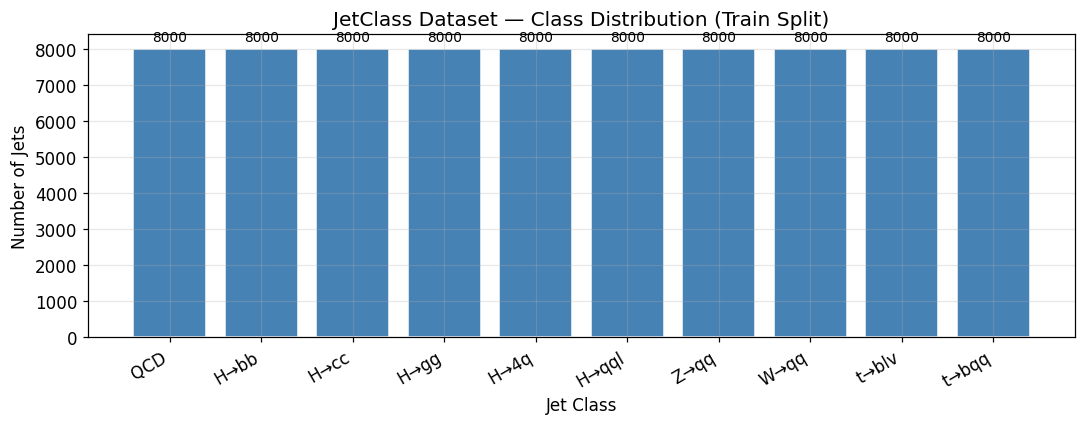


Counts per class: {'QCD': np.int64(8000), 'H→bb': np.int64(8000), 'H→cc': np.int64(8000), 'H→gg': np.int64(8000), 'H→4q': np.int64(8000), 'H→qql': np.int64(8000), 'Z→qq': np.int64(8000), 'W→qq': np.int64(8000), 't→blv': np.int64(8000), 't→bqq': np.int64(8000)}


In [6]:
CLASS_NAMES = {
    0: 'QCD',
    1: 'H→bb',
    2: 'H→cc',
    3: 'H→gg',
    4: 'H→4q',
    5: 'H→qql',
    6: 'Z→qq',
    7: 'W→qq',
    8: 't→blv',
    9: 't→bqq',
}

unique, counts = np.unique(labels, return_counts=True)
class_names = [CLASS_NAMES[i] for i in unique]

fig, ax = plt.subplots(figsize=(10, 4))
bars = ax.bar(class_names, counts, color='steelblue', edgecolor='white')
ax.bar_label(bars, fmt='%d', fontsize=9, padding=3)
ax.set_xlabel('Jet Class')
ax.set_ylabel('Number of Jets')
ax.set_title('JetClass Dataset — Class Distribution (Train Split)')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()
print('\nCounts per class:', dict(zip(class_names, counts)))

## 3. Particle Feature Distributions

Total valid particles: 3,148,838


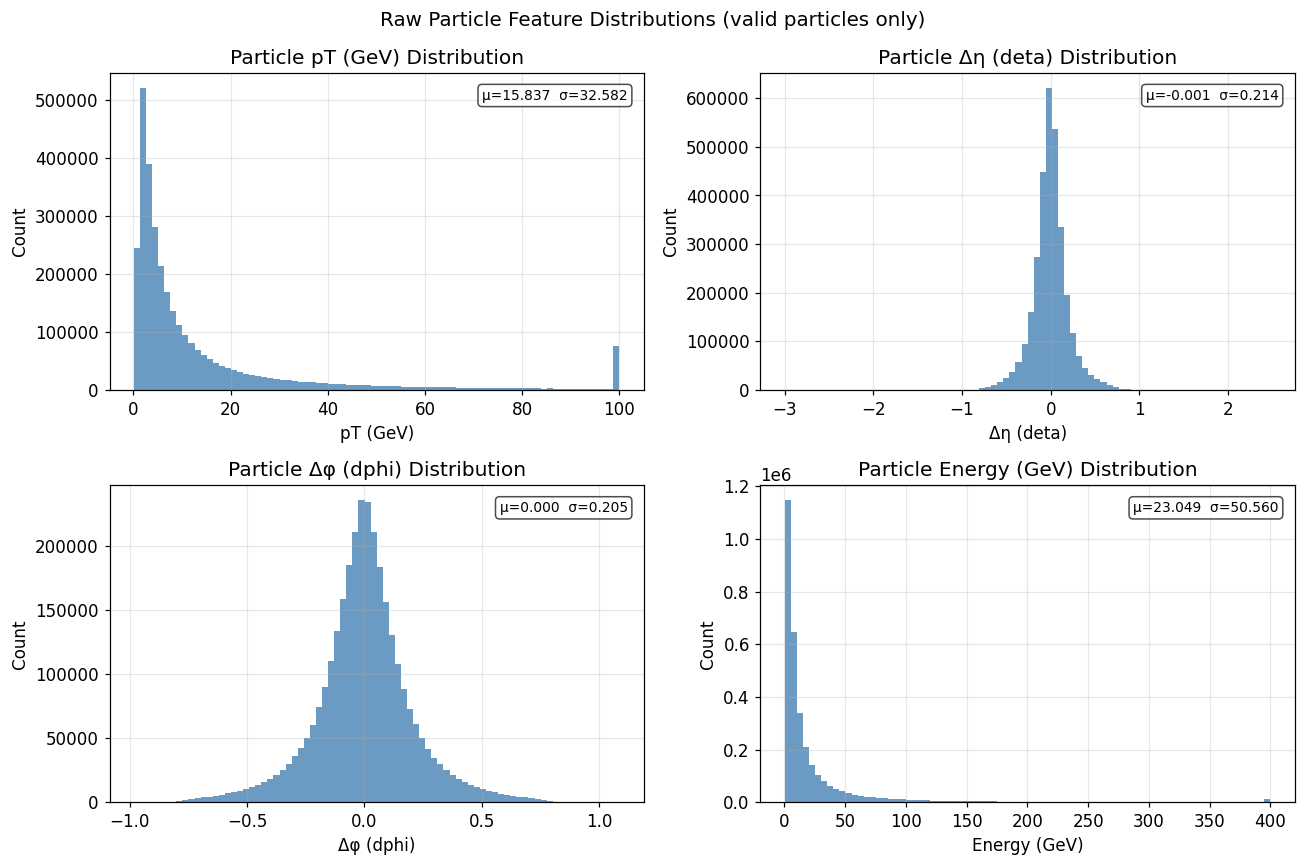

In [7]:
# Gather valid (non-padded) particles only
valid_mask = np.arange(MAX_P)[None, :] < num_parts[:, None]   # (N, 128) bool
valid_particles = particles[valid_mask]   # (M, 4)
print(f'Total valid particles: {len(valid_particles):,}')

feat_names = ['pT (GeV)', 'Δη (deta)', 'Δφ (dphi)', 'Energy (GeV)']
feat_units = ['GeV', '', 'rad', 'GeV']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

clip_ranges = [(0, 100), (-3, 3), (-np.pi, np.pi), (0, 400)]

for i, (ax, name, (lo, hi)) in enumerate(zip(axes, feat_names, clip_ranges)):
    data = np.clip(valid_particles[:, i], lo, hi)
    ax.hist(data, bins=80, color='steelblue', alpha=0.8, edgecolor='none')
    ax.set_xlabel(name)
    ax.set_ylabel('Count')
    ax.set_title(f'Particle {name} Distribution')
    stats_str = f'μ={valid_particles[:,i].mean():.3f}  σ={valid_particles[:,i].std():.3f}'
    ax.text(0.97, 0.95, stats_str, transform=ax.transAxes,
            ha='right', va='top', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.suptitle('Raw Particle Feature Distributions (valid particles only)', fontsize=13)
plt.tight_layout()
plt.show()

**Key observations:**
- **pT and E** are right-skewed (heavy tail) → `log1p` transform needed before z-score
- **dη** is roughly symmetric around 0 → direct z-score is fine
- **dφ** is periodic on [−π, π] → cosine similarity loss used instead of MSE

## 4. Jet Multiplicity

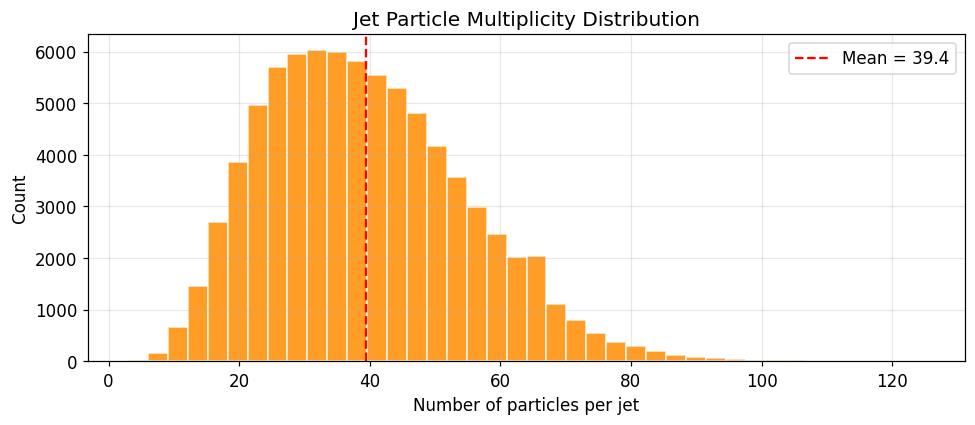

In [8]:
fig, ax = plt.subplots(figsize=(9, 4))
ax.hist(num_parts, bins=40, color='darkorange', alpha=0.85, edgecolor='white')
ax.axvline(num_parts.mean(), color='red', linestyle='--', label=f'Mean = {num_parts.mean():.1f}')
ax.set_xlabel('Number of particles per jet')
ax.set_ylabel('Count')
ax.set_title('Jet Particle Multiplicity Distribution')
ax.legend()
plt.tight_layout()
plt.show()

## 5. Biased Masking Strategy

To avoid the *η-safe / pT-compensation* bias observed in Thanh's 2025 work, I use an **inverse-index pT-weighted sampling** strategy: particles with higher pT (earlier in the sorted list) are masked more often.

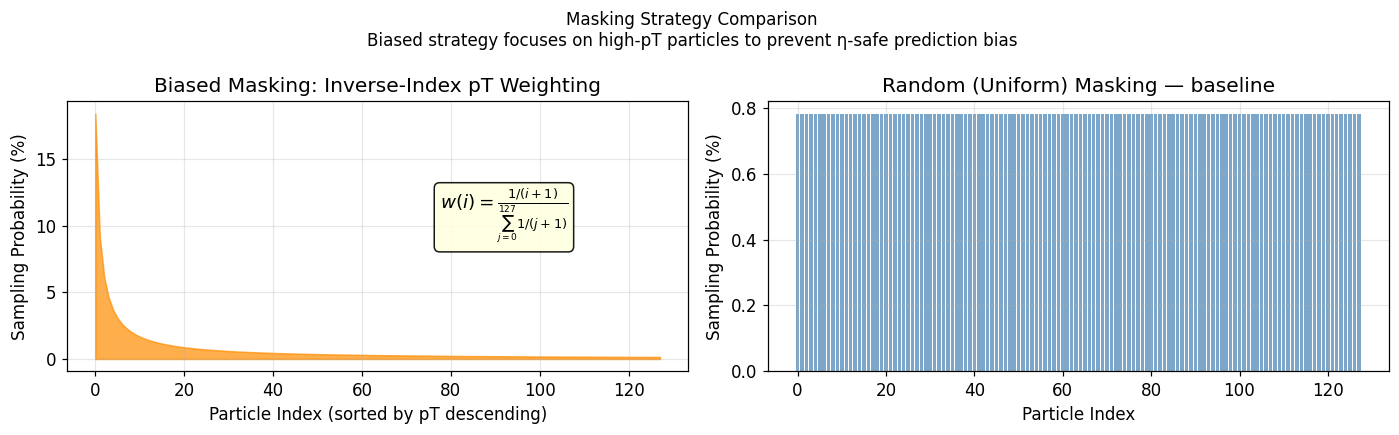

P(mask particle 0)   biased=18.41%  random=0.78%
P(mask particle 63)  biased=0.29%  random=0.78%
P(mask particle 127) biased=0.1438%  random=0.78%


In [ ]:
# Visualise the biased sampling weights  (same formula used in data_factory.py)
N_particles = 128
indices = np.arange(N_particles)

# Biased: proportional to 1/(idx+1), normalised
weights_biased = 1.0 / (indices + 1)
weights_biased /= weights_biased.sum()

# Random: uniform
weights_random = np.ones(N_particles) / N_particles

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

axes[0].fill_between(indices, weights_biased * 100, alpha=0.7, color='darkorange')
axes[0].set_xlabel('Particle Index (sorted by pT descending)')
axes[0].set_ylabel('Sampling Probability (%)')
axes[0].set_title('Biased Masking: Inverse-Index pT Weighting')
axes[0].text(0.6, 0.6,
    r'$w(i) = \frac{1/(i+1)}{\sum_{j=0}^{127} 1/(j+1)}$',
    transform=axes[0].transAxes, fontsize=12,
    bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))

axes[1].bar(indices, weights_random * 100, color='steelblue', alpha=0.7)
axes[1].set_xlabel('Particle Index')
axes[1].set_ylabel('Sampling Probability (%)')
axes[1].set_title('Random (Uniform) Masking — baseline')

plt.suptitle('Masking Strategy Comparison\n'
             'Biased strategy focuses on high-pT particles to prevent η-safe prediction bias',
             fontsize=11)
plt.tight_layout()
plt.show()

# Show probability difference
print(f'P(mask particle 0)   biased={weights_biased[0]*100:.2f}%  random={weights_random[0]*100:.2f}%')
print(f'P(mask particle 63)  biased={weights_biased[63]*100:.2f}%  random={weights_random[63]*100:.2f}%')
print(f'P(mask particle 127) biased={weights_biased[127]*100:.4f}%  random={weights_random[127]*100:.2f}%')

## 6. Normalisation Effect: log1p + z-score on pT

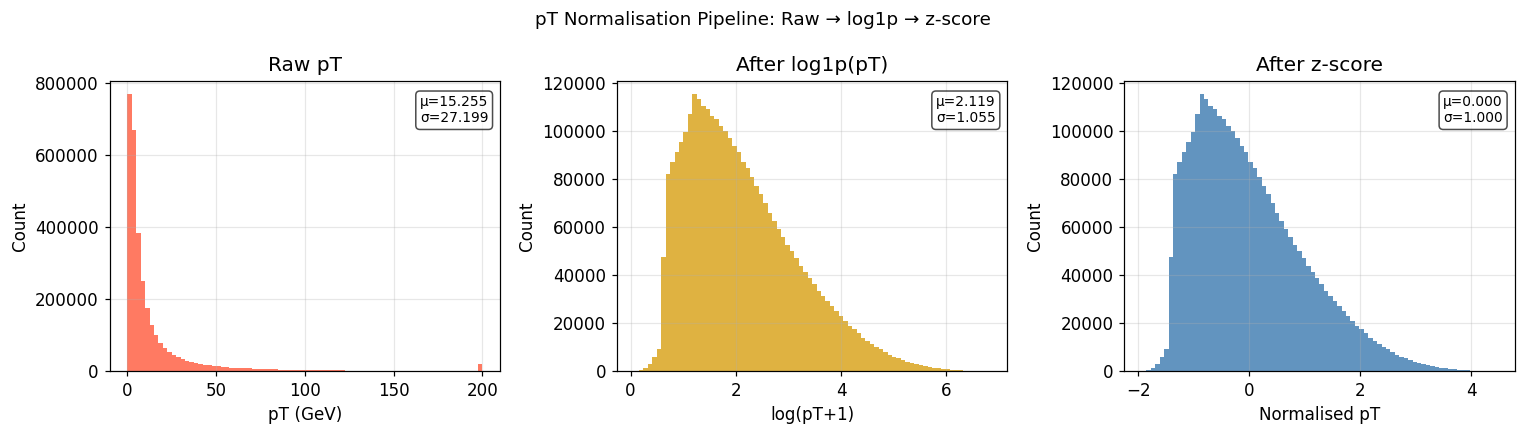

In [11]:
pT_raw  = valid_particles[:, 0]
pT_log  = np.sign(pT_raw) * np.log1p(np.abs(pT_raw))   # log1p, sign-preserving
pT_norm = (pT_log - pT_log.mean()) / (pT_log.std() + 1e-8)  # z-score

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, data, title, xlabel, color in [
    (axes[0], np.clip(pT_raw, 0, 200), 'Raw pT', 'pT (GeV)', 'tomato'),
    (axes[1], pT_log,  'After log1p(pT)',   'log(pT+1)', 'goldenrod'),
    (axes[2], pT_norm, 'After z-score', 'Normalised pT', 'steelblue'),
]:
    ax.hist(data, bins=80, color=color, alpha=0.85, edgecolor='none')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Count')
    ax.set_title(title)
    ax.text(0.97, 0.95,
            f'μ={data.mean():.3f}\nσ={data.std():.3f}',
            transform=ax.transAxes, ha='right', va='top', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.suptitle('pT Normalisation Pipeline: Raw → log1p → z-score', fontsize=12)
plt.tight_layout()
plt.show()

## 7. pT Distribution Per Class

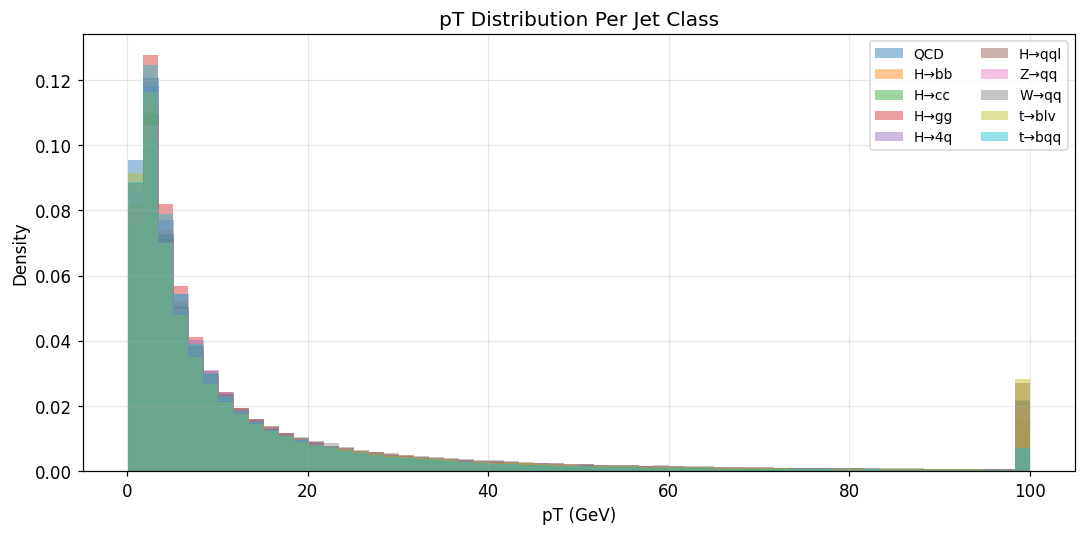

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
cmap = plt.get_cmap('tab10')

for cid in sorted(CLASS_NAMES):
    class_mask = labels == cid                             # jets of this class
    class_valid = np.arange(MAX_P)[None, :] < num_parts[class_mask, None]
    class_pT = particles[class_mask][class_valid][:, 0]   # pT of valid particles
    ax.hist(np.clip(class_pT, 0, 100), bins=60, alpha=0.45,
            label=CLASS_NAMES[cid], color=cmap(cid), density=True)

ax.set_xlabel('pT (GeV)')
ax.set_ylabel('Density')
ax.set_title('pT Distribution Per Jet Class')
ax.legend(fontsize=9, ncol=2)
plt.tight_layout()
plt.show()

## Summary

| Feature | Challenge | Solution in this project |
|---------|-----------|---------------------------|
| **pT, E** | Right-skewed (GeV scale) | `log1p` → z-score normalisation |
| **dη** | Symmetric, small range | Direct z-score |
| **dφ** | Periodic on [−π, π] | **Unchanged** — cosine loss handles periodicity |
| **Masking bias** | Model predicts safe η≈0 | Biased pT-weighted masking |
| **Class imbalance** | 10 balanced classes | Balanced sampling in preprocessing |